In [71]:
import os
import subprocess
from datetime import datetime
import argparse

class Variable:
    def __init__(self, number, negate):
        self.number = number
        self.negate = negate

    def call(self, arr):
        return bool(arr[self.number]) ^ self.negate


class Sat:
    def __init__(self, size, clauses):
        self.size = size
        self.clauses = clauses

    def call(self, arr):
        return all([any([x.call(arr) for x in cl]) for cl in self.clauses])


class OptExternalSatSolver:
    def __init__(self, solver_name):
        self.solver_name = solver_name

    def solve(self, sat):
        p = subprocess.Popen(
            ['cargo', 'run', '--bin', f'test_{self.solver_name}_solver'],
            stdin=subprocess.PIPE,
            stdout=subprocess.PIPE,
            stderr=subprocess.DEVNULL
        )

        p.communicate(("\n".join(get_printable_sat(sat))).encode())
        p.wait()

        stdout, stderr = p.communicate()
        output = stdout.decode()
        return output


def resolve_testcases(path):
    folder = os.fsencode(path)

    filenames = []

    for file in os.listdir(folder):
        filename = os.fsdecode(file)
        if filename.endswith(('.cnf', '.txt')):
            filenames.append(filename)

    return filenames


def parse_testcase(path):
    lines = []
    with open(path, 'r') as f:
        lines =  f.readlines()

    clauses = []
    num_clauses = 0
    num_variables = 0

    for line in lines:
        if len(line) == 0 or line[0] == 'c':
            continue

        if line[0] == 'p':
            p, cnf, n, m = line.split()
            num_variables = int(n)
            num_clauses = int(m)
            continue
        
        if line[0] == '%':
            break

        literals = map(int, line.split())

        clause = []
        for l in literals:
            if l == 0:
                break

            number = abs(l)
            negate = (l < 0)
            clause.append(Variable(number, negate))
        
        clauses.append(clause)

    assert len(clauses) == num_clauses

    return Sat(num_variables, clauses)


def get_printable_sat(sat):
    lines = []
    lines.append(f"{len(sat.clauses)}")
    for clause in sat.clauses:
        printable_clause = [str(v.number * (-1) ** v.negate) for v in clause]
        lines.append(" ".join(printable_clause))
    return lines


def check_testcase(cnf, output, time_elapsed, testcase_name=''):
    if len(output) == 0:
        return False
    
    if output[0] == 'E':
        return False
    
    values = list(map(int, output.split()))

    eval_set = [0] * (cnf.size + 1)

    for v in values:
        if v > 0:
            eval_set[v] = 1

    if cnf.call(eval_set) == False:
        return False

    return True

from random import randint

def run_testcase(cnf, solver, testcase_name=''):
#     if randint(0, 3) == 3:
#         return None

    timer_start = datetime.now()

    output = solver.solve(cnf)

    timer_end = datetime.now()
    time_elapsed = timer_end - timer_start

    if check_testcase(cnf, output, time_elapsed, testcase_name):
        return time_elapsed

    return None


def get_test_time(solver, tc):
    cnf = parse_testcase(tc)
    return run_testcase(cnf, solver, tc)

Посмотрим на среднее время решения тестов для различного количества переменных.

In [85]:
from tqdm import tqdm
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_performance_graph(solver, tests, total_tests):
    testcases_path = './testcases/'

    fails_stats = []
    time_stats = []
    
    for num_vars in tests:
        print(f"Testing with {num_vars} variables:")
        
        fails = 0
        stats = []
        
        path = testcases_path + str(num_vars)
        testcases = resolve_testcases(path)
        
        total_testcases = len(testcases)

        for tc in tqdm(testcases):
            time = get_test_time(solver, path + '/' + tc)
            if time is None:
                fails += 1
                continue

            stats.append(time)

        fail_rate = fails / total_testcases
        average_time = np.mean(stats).total_seconds()

        fails_stats.append(fail_rate)
        time_stats.append(average_time)
    
    time_df = pd.DataFrame(data={
        'variables': tests,
        'avg_time': time_stats
    })
    
    fails_df = pd.DataFrame(data={
        'variables': tests,
        'fails': fails_stats
    })
    

    sns.lineplot(time_df, x='variables', y='avg_time', linewidth=5)
    plt.xlabel("Количество переменных в 3-КНФ")
    plt.ylabel("Среднее время в секундах")
    plt.xticks(total_tests)
    plt.show()
    print(time_df)
    
    sns.barplot(fails_df, x='variables', y='fails')
    plt.xlabel("Количество переменных в 3-КНФ")
    plt.ylabel("Доля неудач")
    plt.yticks(np.linspace(0, 1, 10))
    plt.xticks(total_tests)
    plt.show()

    print(fails_df)


Testing with 20 variables:


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]


Testing with 50 variables:


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.89it/s]


Testing with 75 variables:


100%|███████████████████████████████████████████| 10/10 [00:37<00:00,  3.73s/it]


Testing with 100 variables:


100%|███████████████████████████████████████████| 10/10 [07:57<00:00, 47.78s/it]


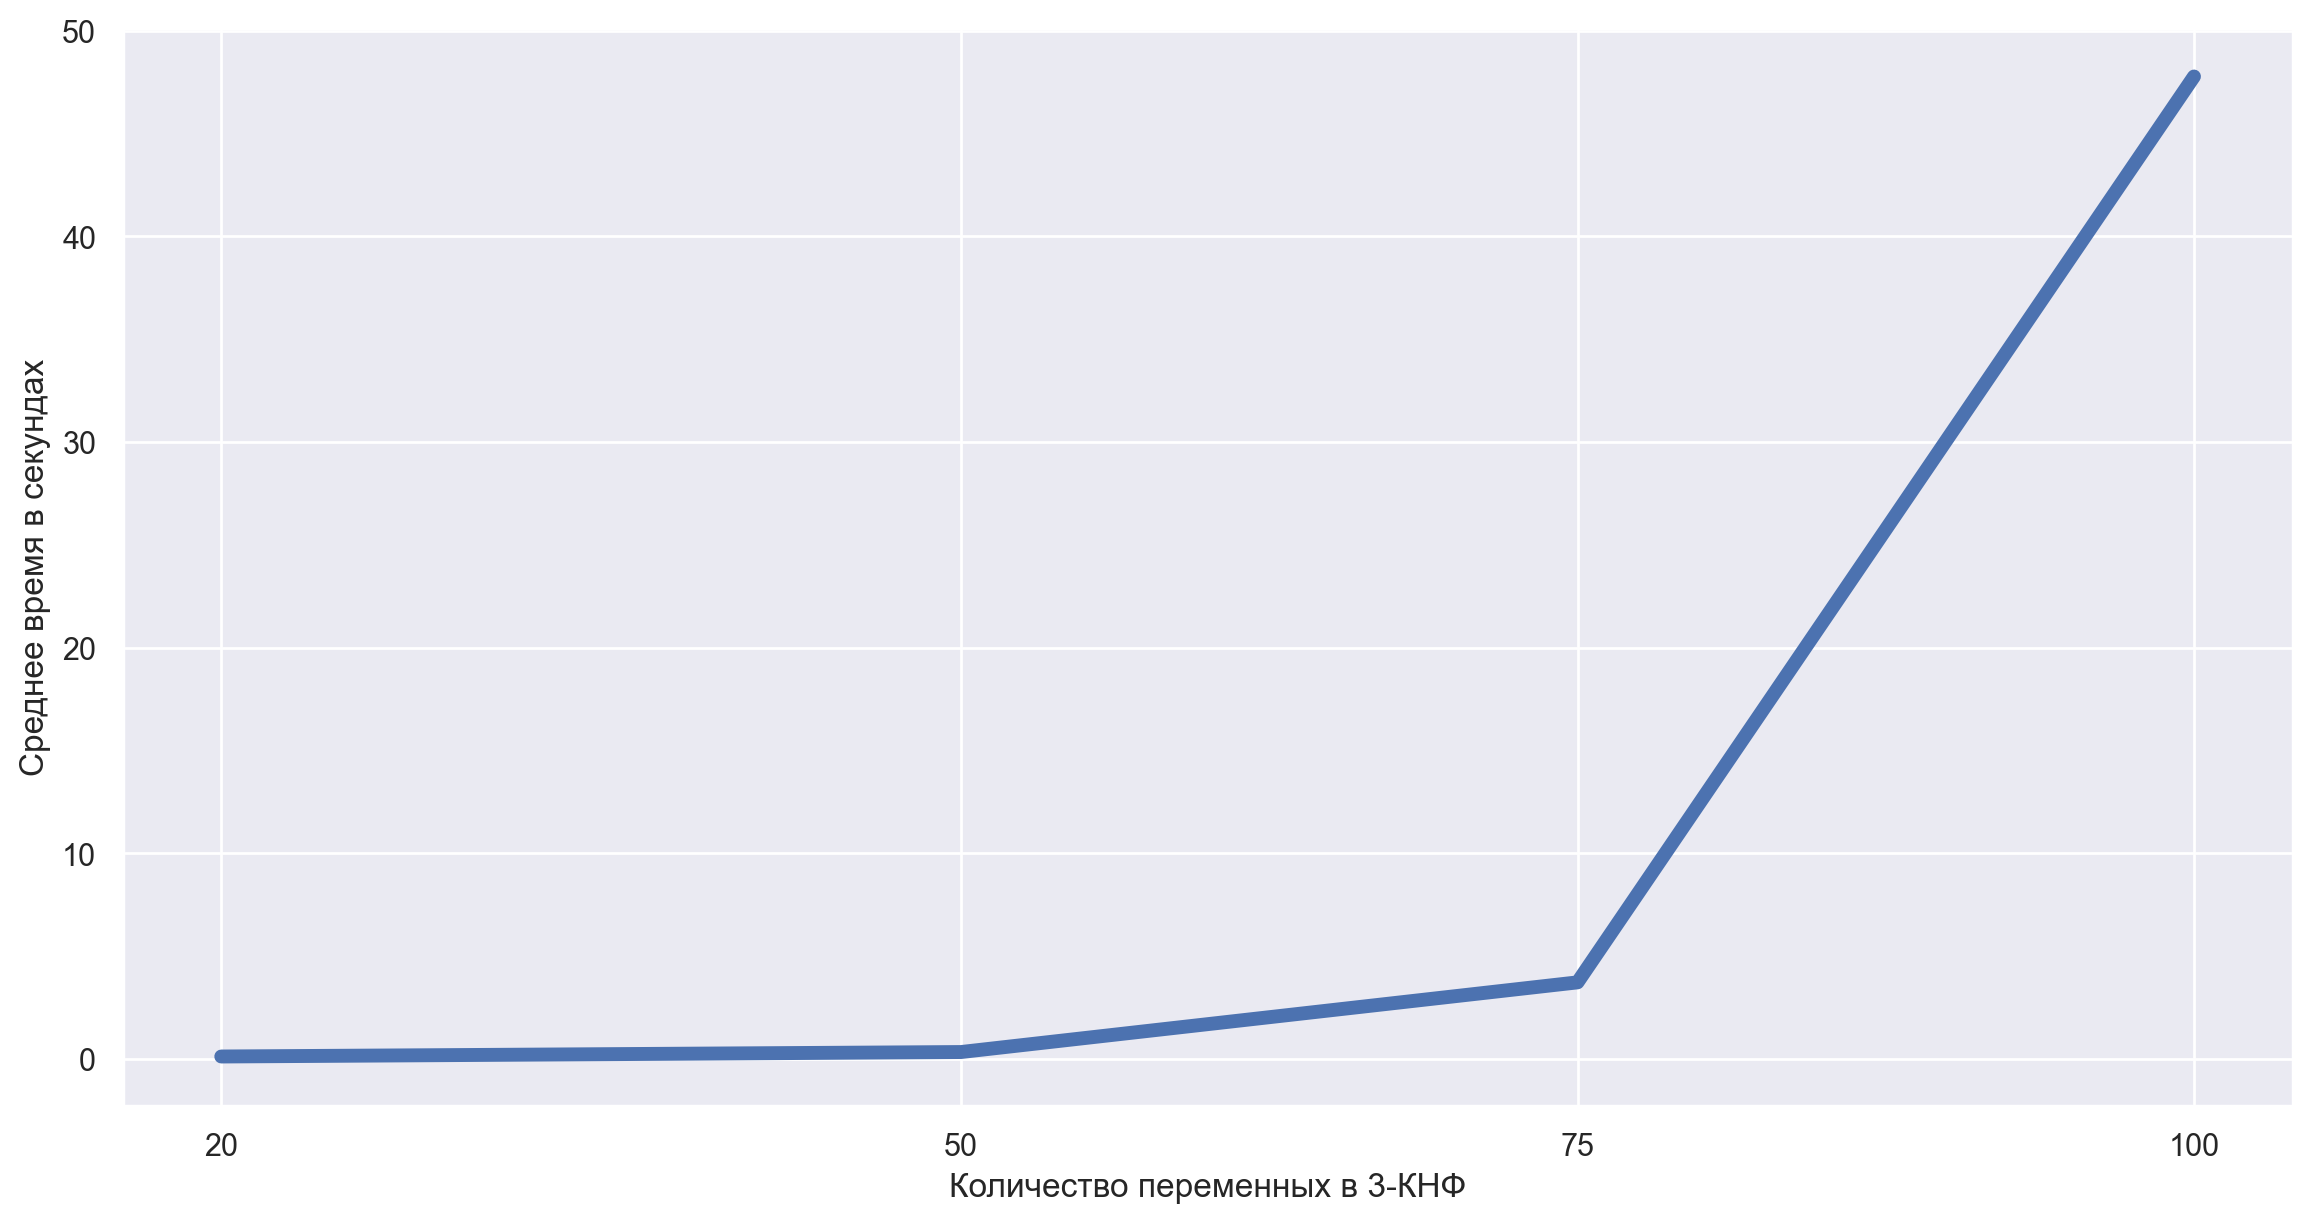

   variables   avg_time
0         20   0.125329
1         50   0.342584
2         75   3.729690
3        100  47.773116


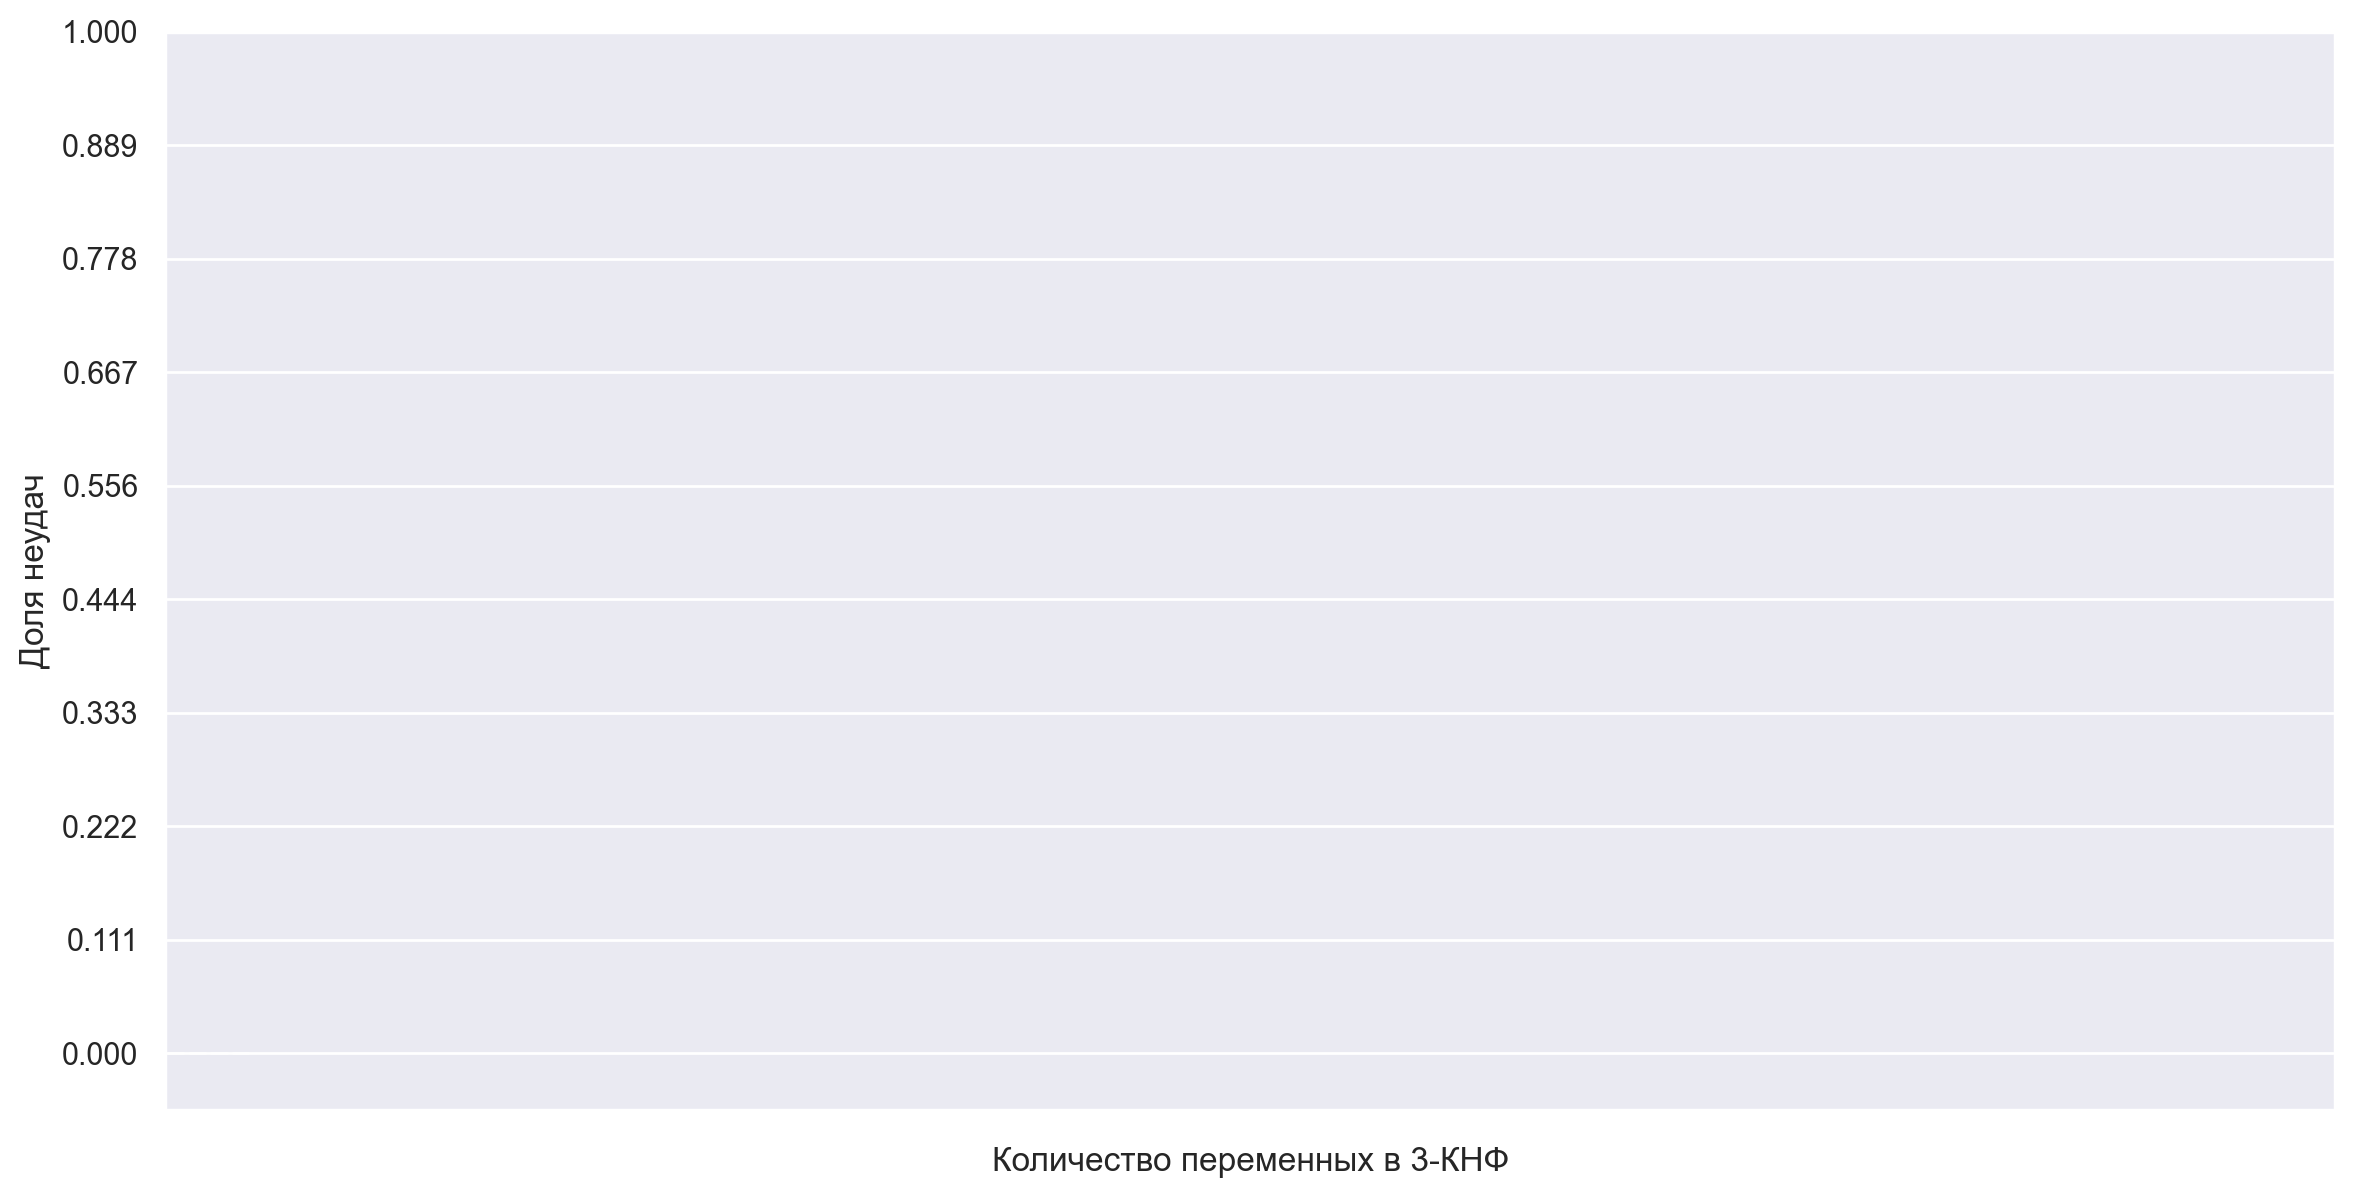

   variables  fails
0         20    0.0
1         50    0.0
2         75    0.0
3        100    0.0


In [87]:
sns.set_style('darkgrid')
sns.set(rc={'figure.dpi': 200})
sns.set(rc={'figure.figsize':(14, 7)})

solver = OptExternalSatSolver('dpll')
plot_performance_graph(solver, [20, 50, 75, 100], [20, 50, 75, 100])

Testing with 20 variables:


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.17it/s]


Testing with 50 variables:


100%|███████████████████████████████████████████| 10/10 [07:16<00:00, 43.65s/it]


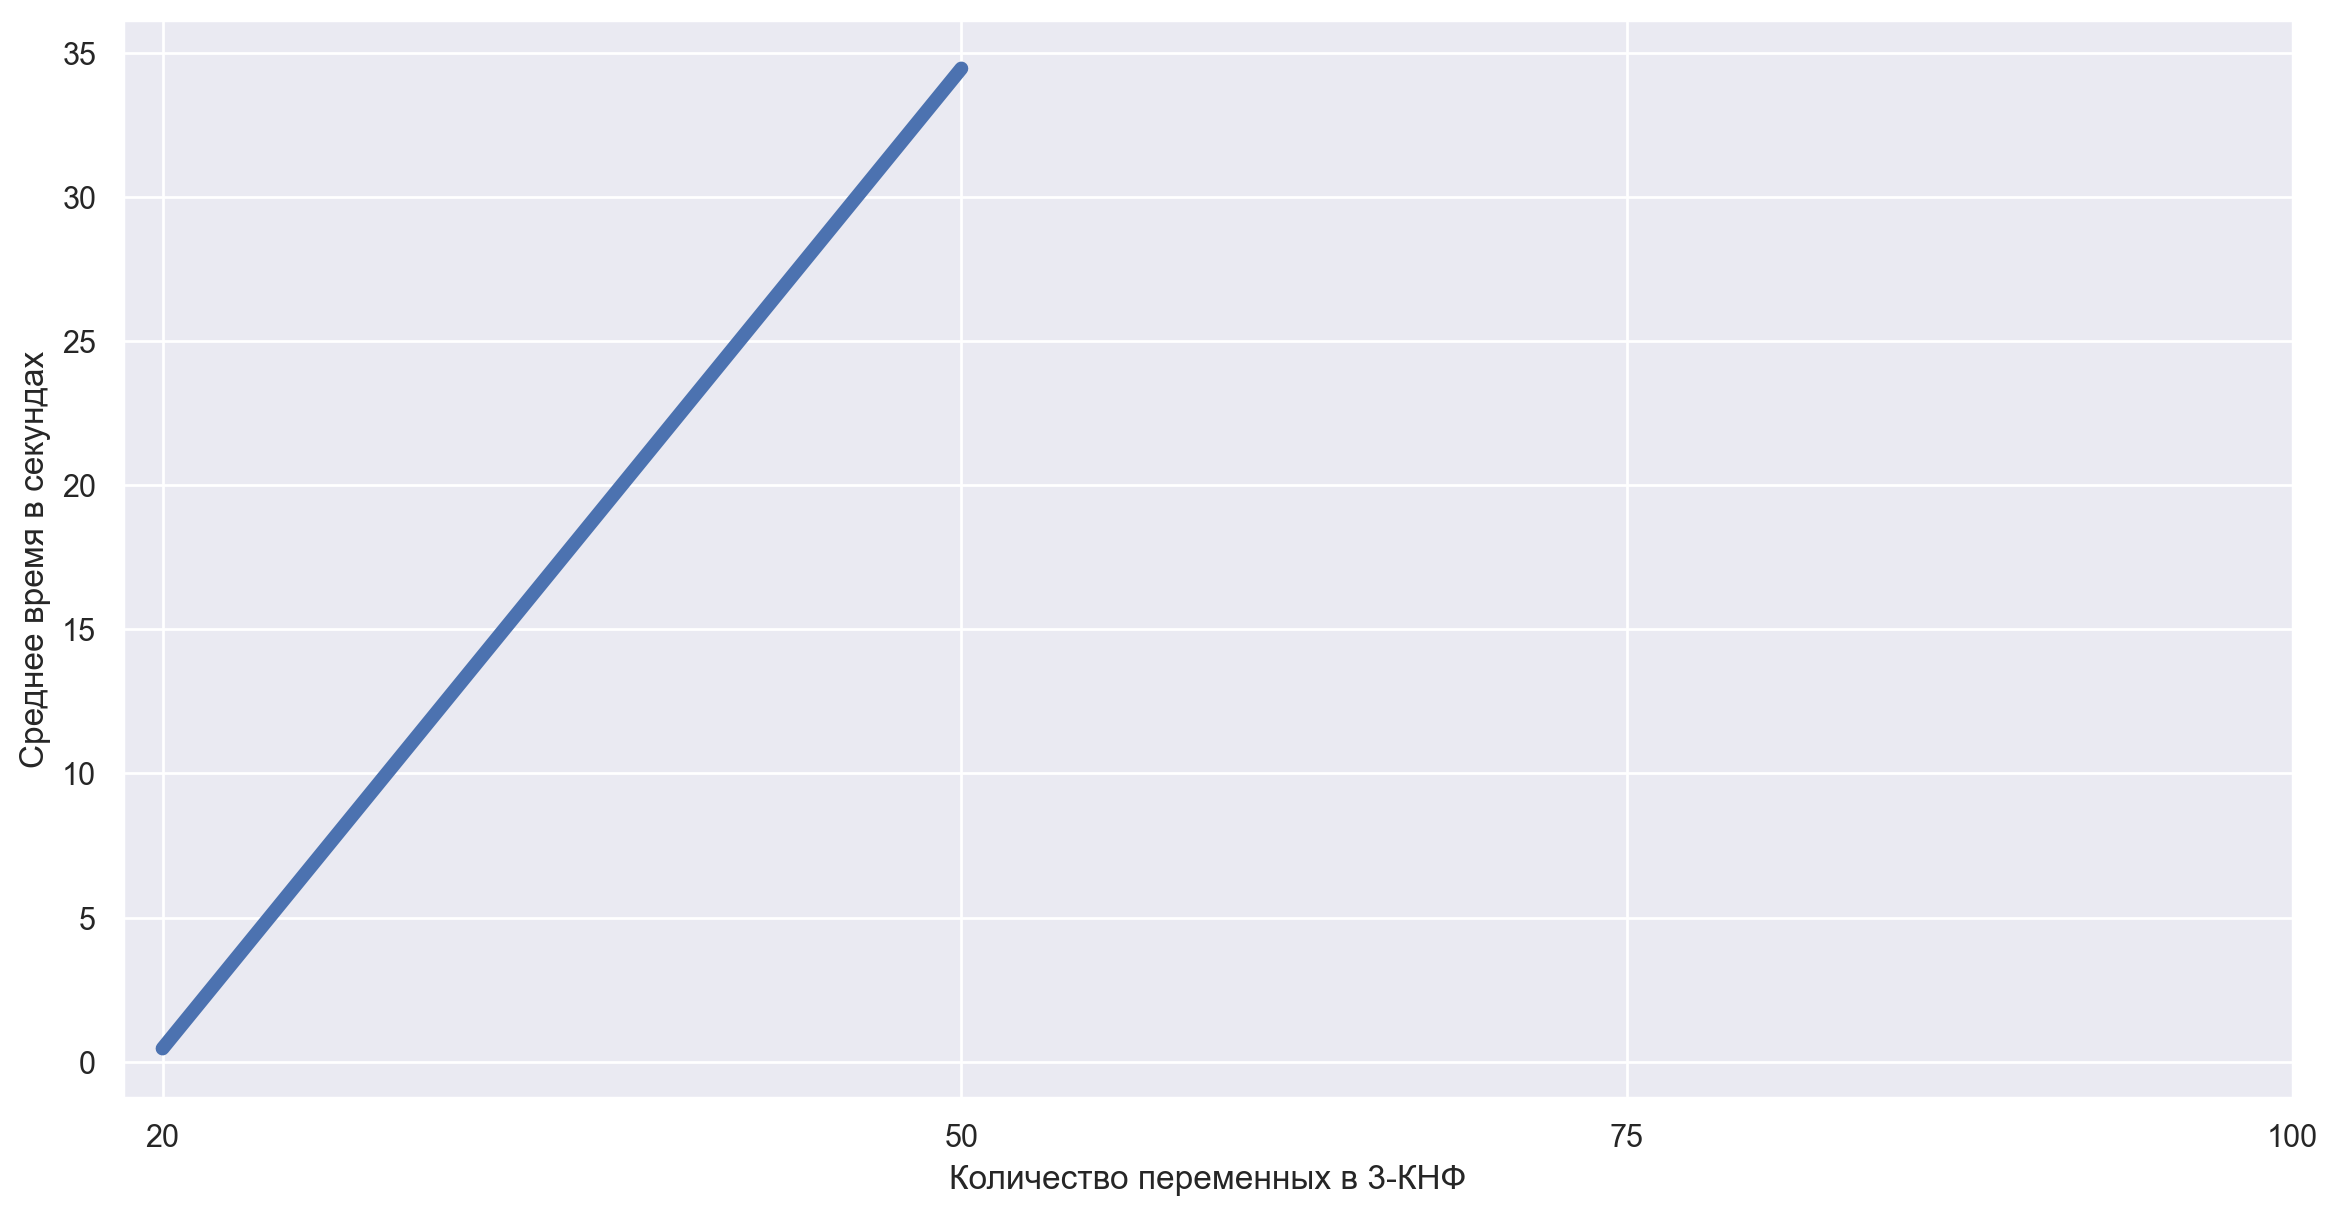

   variables   avg_time
0         20   0.456249
1         50  34.454188


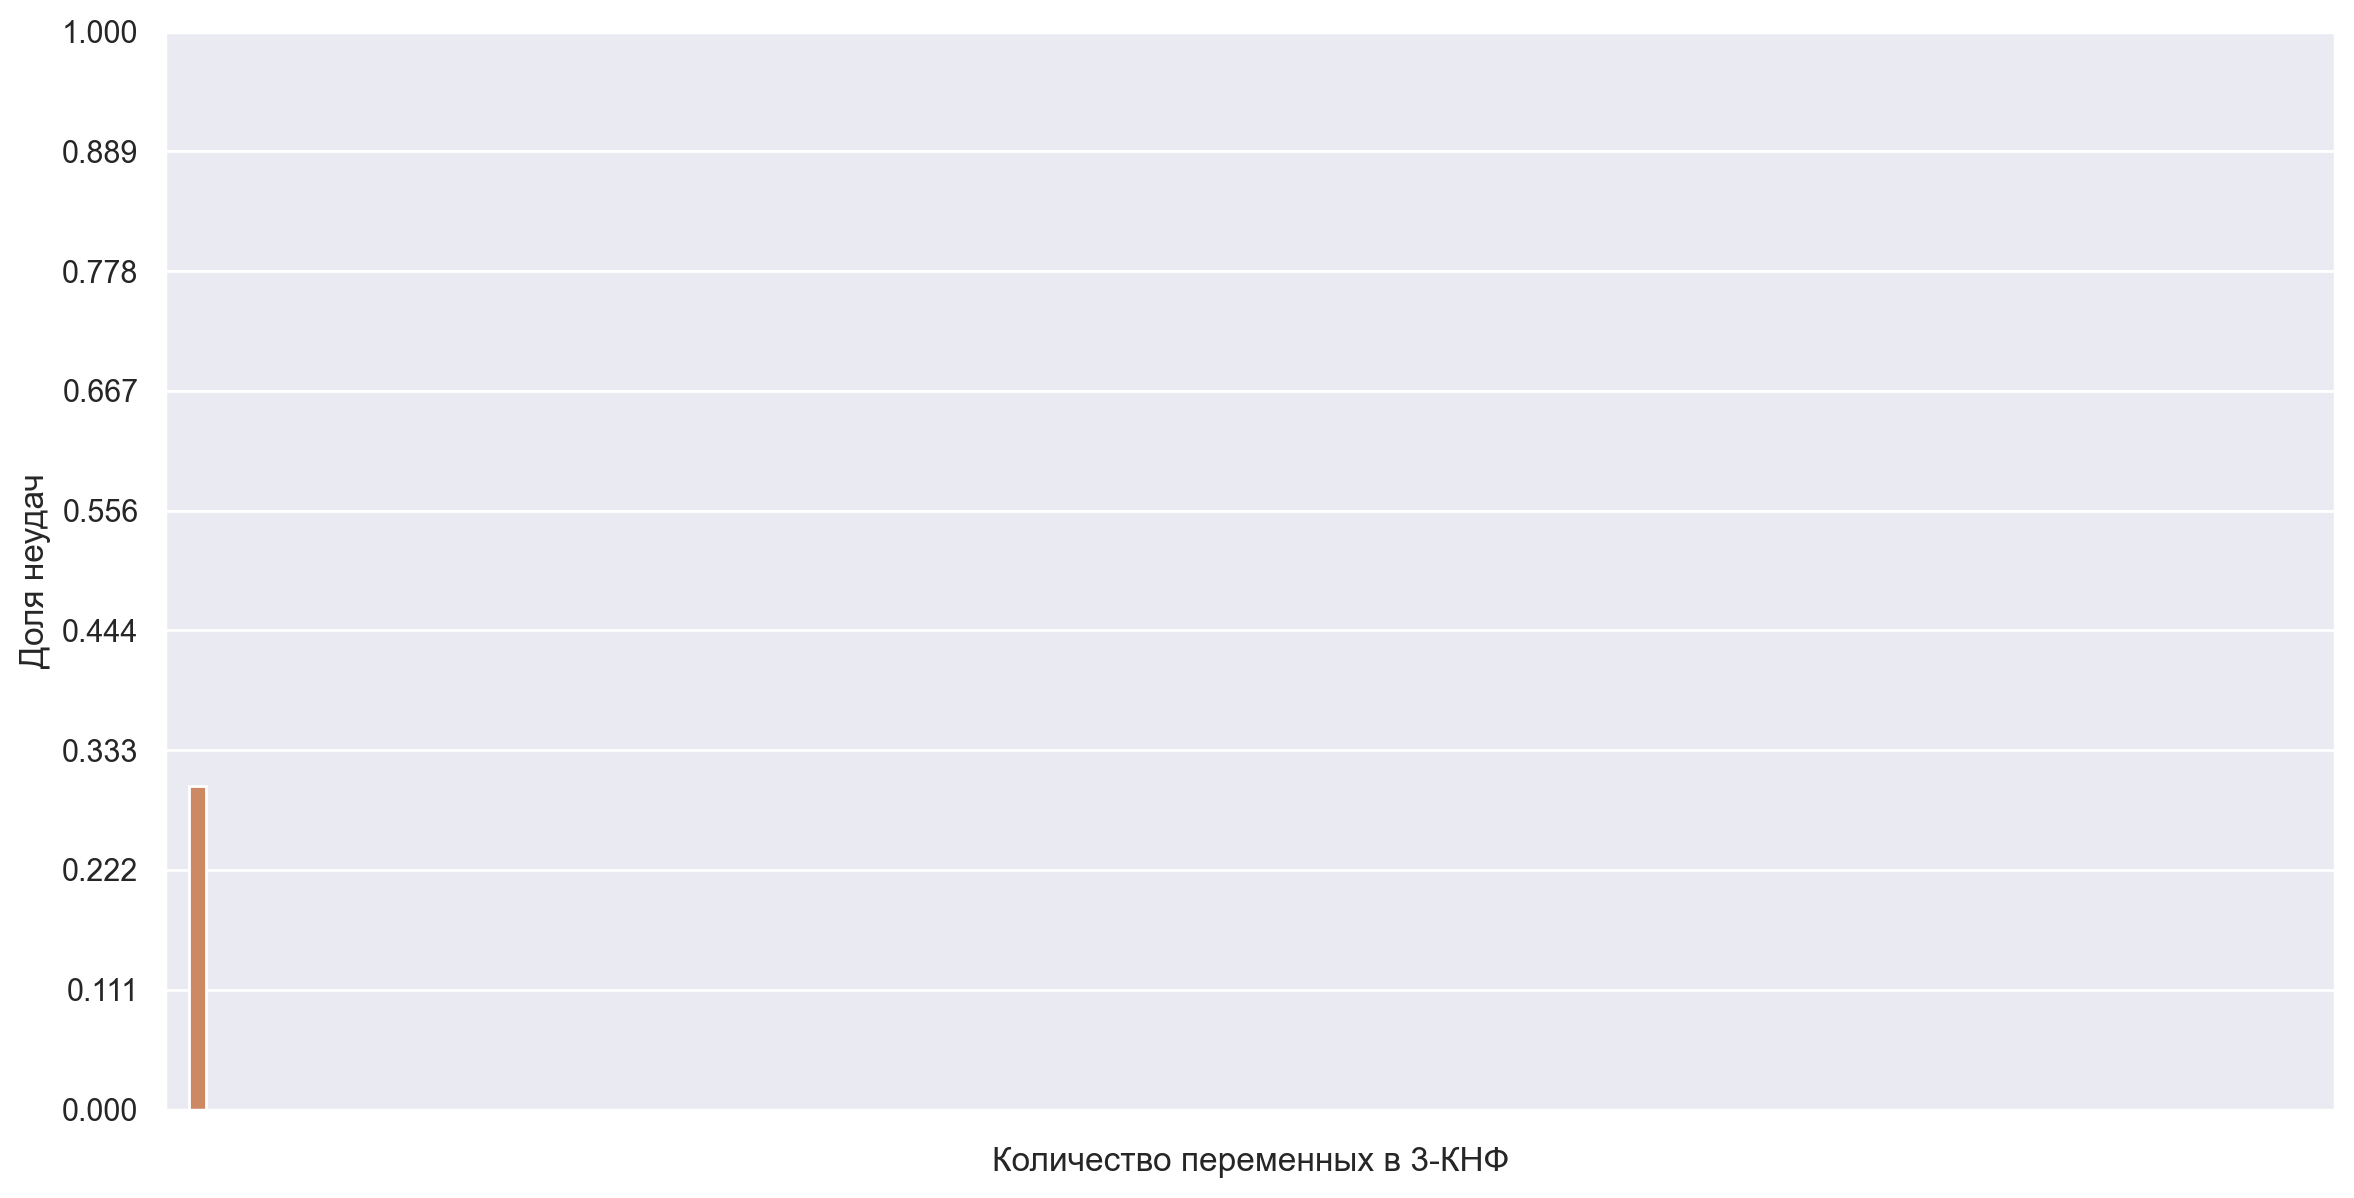

   variables  fails
0         20    0.0
1         50    0.3


In [88]:
sns.set_style('darkgrid')
sns.set(rc={'figure.dpi': 200})
sns.set(rc={'figure.figsize':(14, 7)})

solver = OptExternalSatSolver('ppsz')
plot_performance_graph(solver, [20, 50], [20, 50, 75, 100])